In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, value_and_grad
import numpy as np

import sys

# Add the directory to sys.path
scripts = '../scripts'
sys.path.append(scripts)

from stasis_simulation_differentiable import StasisSolver
from stasis_simulation_non_diff import NonDiffStasisSolver
from stasis_utils import bitonic_sort


With a differentiable stasis simulation, we have the liberty to use gradients to study the input parameter space conditioned on high $e$-folds of stasis. The simulation $\mathcal{S}(\Omega_\ell^{(0)}, \Gamma_\ell)$ returns the number of $e$-folds of stasis epoch $\mathcal{N}$ and the abundance $\overline{\Omega}_M$. By setting an optimization objective of high $\mathcal{N}$, we can employ gradient *ascent* to find values of $\Omega_\ell^{(0)}$ and $\Gamma_\ell$ that yield high stasis.

We begin by defining the optimization objective $f$. Let

$$
f(\theta) = \mathcal{N}(\theta) - \alpha \left[(\overline{\Omega}_M(\theta) - l)^2 + (\overline{\Omega}_M(\theta) - u)^2 \right]
 \times \left(1 - \Theta(\overline{\Omega}_M(\theta) - l) \Theta(u - \overline{\Omega}_M(\theta)) \right) \nonumber \; , 
$$

where the first term encourages high $e$-folds and the second term is a regularization term to make sure a potential stasis epoch is mixed component. $l$ and $u$ define bounds on $\overline{\Omega}_M$ to encourage mixed component cosmologies. We use $l = 0.2$, $u = 0.8$, and $\alpha = 10$, the latter of which ensures the regularization condition is strong enough. We are ready to define $f$ below:

In [2]:
@jit
def stasis_loss(Omega_0, Gamma_0, H_0=1.0, log_transform=True, use_adjoint=False):
    sim = StasisSolver(Omega_0, Gamma_0, H_0, log_transform=log_transform, use_adjoint=use_adjoint)
    stasis_val, asymptote_val = sim.return_stasis()
    return stasis_val, asymptote_val

@jit
def regularization_fn(asymptote_val, lower_bound, upper_bound):
    penalty = jnp.where((asymptote_val < lower_bound) | (asymptote_val > upper_bound),
                        (asymptote_val - lower_bound) ** 2 + (asymptote_val - upper_bound) ** 2, 0)
    return penalty

@jit
def optimization_fn(params):
    Omega_0, Gamma_0 = params
    stasis_val, asymptote_val = stasis_loss(Omega_0, Gamma_0)
    
    lower_bound = 0.2
    upper_bound = 0.8
    
    asymptote_penalty = regularization_fn(asymptote_val, lower_bound, upper_bound)
    
    combined_value = stasis_val - 10*asymptote_penalty
    
    return combined_value

We now must define the update for an individual gradient ascent step. With the gradients of $f$ available, $\nabla_{\Gamma_{\ell,i}} f(\theta)$ and $\nabla_{\Omega_{\ell,i}}^{(0)} f(\theta)$ for a given step $i$, we can compute the values for the sequential step $i+1$ as:

\begin{equation}
\begin{aligned}
    \Omega_{\ell,i+1}^{(0)} &= \Omega_{\ell,i}^{(0)} + \eta(t) \nabla_{\Omega_{\ell,i}^{(0)}} f(\theta) \\[10pt]
    \Gamma_{\ell,i+1} &= \Gamma_{\ell,i} + \eta(t) \nabla_{\Gamma_{\ell,i}} f(\theta)
\end{aligned}
\end{equation}

where $\eta(t)$ is a potentially time-dependent learning rate. In code, we write the gradient step as


In [3]:
@jit
def gradient_ascent_step(params, learning_rate):
    value, gradients = value_and_grad(optimization_fn)(params)
    new_params = [param + learning_rate * grad for param, grad in zip(params, gradients)]
    return new_params, value

It only remains now to initialize $\Omega_\ell^{(0)}$ and $\Gamma_\ell$. In our analysis, running gradient ascent on $\Omega_\ell^{(0)}, \Gamma_\ell \sim U(0,1)$ initially motivated log-uniformly distributed rates and abundances. As discussed in the paper, this initialization required more training steps and was noisier to convergence. I wont train it for too many steps, but this will still get the functionality across. Lets initialize our parameters and see how they look, and what kind of stasis configuration they yield.

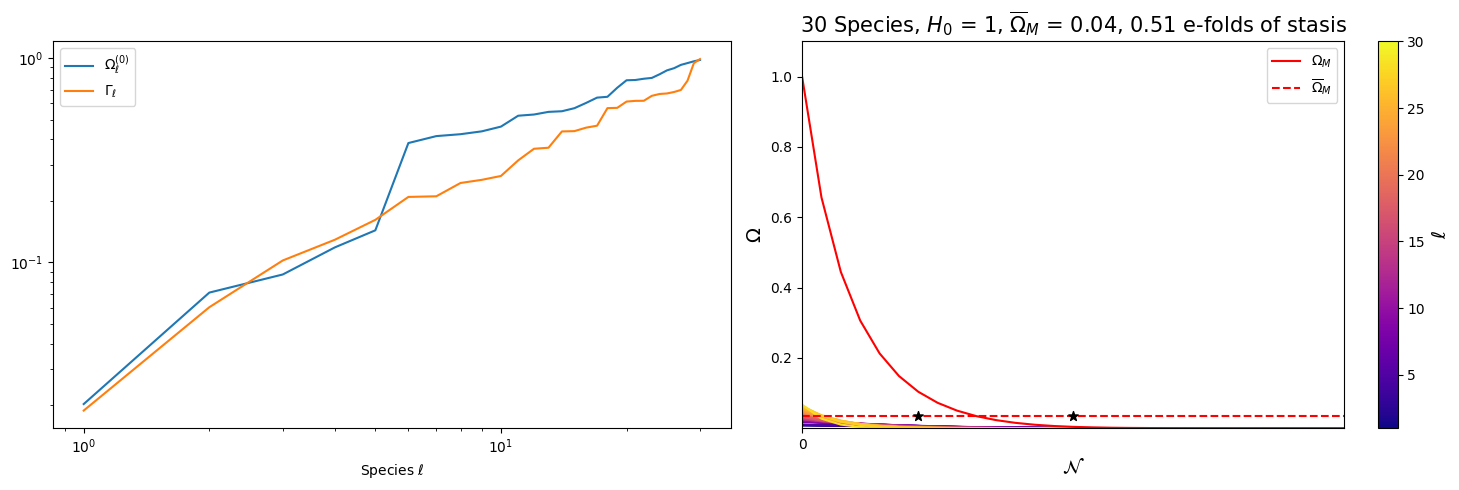

In [4]:
N = 30
species = np.linspace(1, N, N)
Omega_0_init = np.sort(np.random.uniform(0, 1, N))
Gamma_0_init = np.sort(np.random.uniform(0, 1, N))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(species, Omega_0_init, label=r'$\Omega_\ell^{(0)}$')
ax[0].plot(species, Gamma_0_init, label=r'$\Gamma_\ell$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel(r'Species $\ell$')

sim = NonDiffStasisSolver(Omega_0 = 10**(Omega_0_init), Gamma_0 = 10**(Gamma_0_init))
sim.return_stasis()
sim.plot_abundance(ax = ax[1])
plt.tight_layout()
plt.show()

These are approximately linear in log-log space, indicative of being power-law distributed.

We're ready to run the gradient ascent. We train for a total of 10000 steps with an initial learning rate of $\eta = .01$, and use an early stopping patience $\xi =  1000$ epochs. This is shorter than what was used for our main results, but it can get the point across. We also collect trajectories during training so we can later visualize the gradient ascent optimization. **This may take a while if running locally on your machine**; it took about 5 minutes on my laptop. If running on GPU/TPU, jax should automatically leverage the hardware, if you have a proper install.

Here, we also note that our optimization is done in log space. Jax is concerned with the differentiability of functions; the derivative of an $\mathcal{O}(1)$ or $\mathcal{O}(10)$ number is much more well-behaved than the derivative of the actual rates and abundances.

In [5]:
np.random.seed(3) ## arbitrary

params = [jnp.log10(Omega_0_init), jnp.log10(Gamma_0_init)]

num_steps = 10000
patience = 1000
learning_rate = .01

gamma_vals = np.empty((num_steps, N))
omega_vals = np.empty((num_steps, N))
best_loss_value = -jnp.inf
losses = []
epochs_without_improvement = 0

for step in range(num_steps):
    epochs_without_improvement += 1
    params, current_value = gradient_ascent_step(params, learning_rate)
    losses.append(current_value)

    params[0] = bitonic_sort(params[0])
    params[1] = bitonic_sort(params[1])
    Gamma_0 = params[1]
    Gamma_0 = jnp.clip(Gamma_0, -62, 0)
    params[1] = Gamma_0
    gamma_vals[step] = Gamma_0
    omega_vals[step] = params[0]
    
    if jnp.isnan(jnp.array(params)).any() or jnp.isinf(jnp.array(params)).any():
        print(f"Step {step}: NaN or inf encountered. Exiting.")
        break
    
    if step % 500 == 0:
        print(f"Step {step}: Combined objective value = {current_value}")
        
    if current_value > best_loss_value:
        best_value = current_value
        best_params = params
        epochs_without_improvement = 0
        
    if epochs_without_improvement > patience:
        print(f"Exiting early after {step} steps.")
        break
    
    final_params = params

Omega_0_opt, Gamma_0_opt = best_params
print(f"Optimized Omega_0: {Omega_0_opt}")
print(f"Optimized Gamma_0: {Gamma_0_opt}")

Step 0: Combined objective value = -4.929033484990697
Step 500: Combined objective value = 2.7964933810844204
Step 1000: Combined objective value = 4.255765629888063
Step 1500: Combined objective value = 5.21230022575118
Step 2000: Combined objective value = 5.853333022664704
Step 2500: Combined objective value = 6.25964015157009
Step 3000: Combined objective value = 6.458746087495883
Step 3500: Combined objective value = 6.932039311415962
Step 4000: Combined objective value = 7.11353275085012
Step 4500: Combined objective value = 7.252953730465966
Step 5000: Combined objective value = 4.952283069662952
Step 5500: Combined objective value = 8.642340151322877
Step 6000: Combined objective value = 5.078710483027976
Step 6500: Combined objective value = 8.729840506051884
Step 7000: Combined objective value = 5.308763449391897
Step 7500: Combined objective value = 8.809557167741104
Step 8000: Combined objective value = 5.2787823099987
Step 8500: Combined objective value = 5.3457313392529
S

Lets visualize the loss and final stasis configuration.

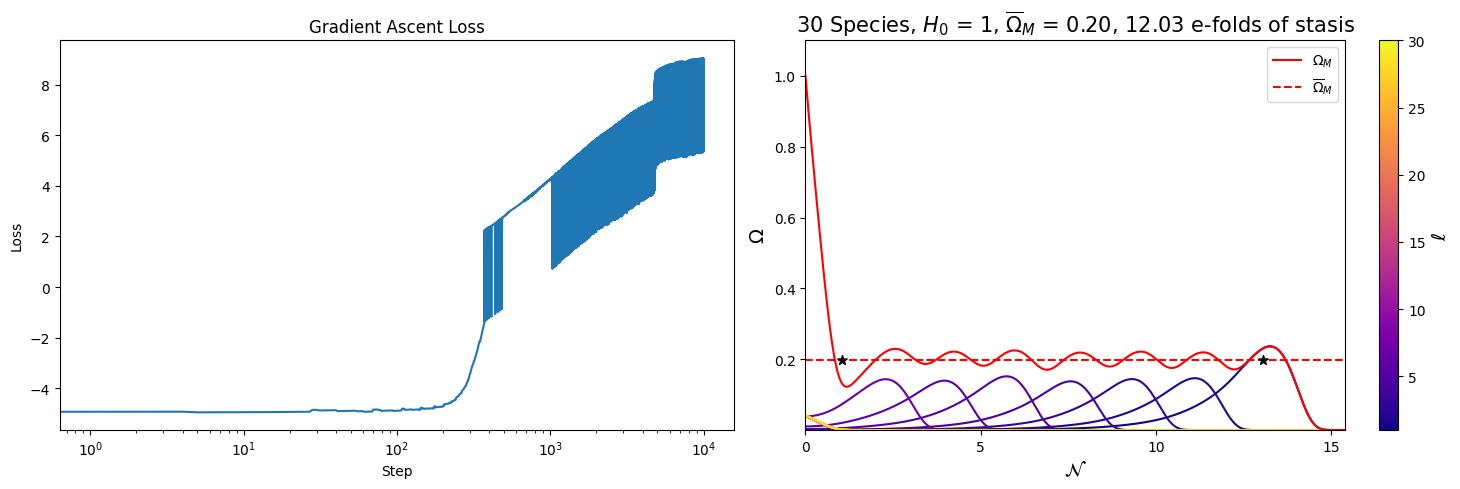

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(losses)
axs[0].set_title("Gradient Ascent Loss", color = 'black')
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].set_xscale('log')


Omega_0_opt, Gamma_0_opt = best_params
sim = NonDiffStasisSolver(Omega_0=np.sort(10**(Omega_0_opt)), Gamma_0=np.sort(10**(Gamma_0_opt)), H_0=1)
sim.return_stasis()
sim.plot_abundance(ax = axs[1])
plt.tight_layout()

Stasis! As we can see, the stasis epoch settled on the lower bound of allowed $\overline{\Omega}_M$. We also see the optimization could have gone on for longer. Those constant spikes in the loss are when the regularization condition kicks in (when $0.2 < \overline{\Omega}_M < 0.8$ is not satisifed). Lets now look to see how $\Omega_\ell^{(0)}$ and $\Gamma_\ell$ are distributed. We can do this quickly by inspection of their spectra.

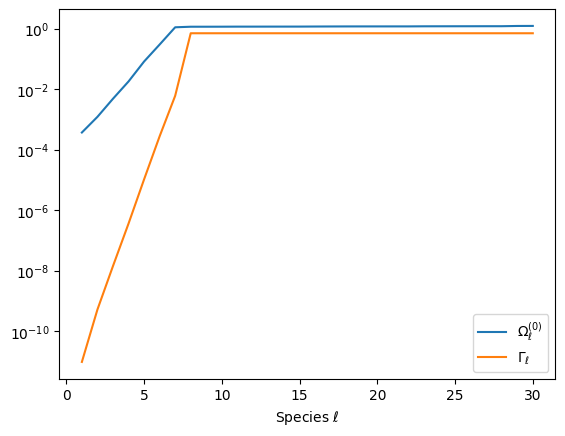

In [7]:
plt.plot(species, 10**(Omega_0_opt), label=r'$\Omega_\ell^{(0)}$')
plt.plot(species, 10**(Gamma_0_opt), label=r'$\Gamma_\ell$')
plt.xlabel(r'Species $\ell$')
plt.yscale('log')
plt.legend()

We see that this is linear on a semi-log plot up to the species contributing to the stasis duration, thus there's been a parameter flow from power-law to exponential via the gradient ascent. Optimizing for more time will result in more of the species contributing to the stasis epoch. Lastly, as a treat lets visualize our optimization trajectories with a gif :)

In [8]:
import os
from joblib import Parallel, delayed
from io import BytesIO

def make_trajectory_plots(gamma_val, omega_val, index):
    sim = NonDiffStasisSolver(Omega_0=10**(omega_val), Gamma_0=10**(gamma_val), H_0=1)
    sim.return_stasis()
    sim.plot_abundance()
    plt.tight_layout()
    
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    plt.close(fig)
    
    buffer.seek(0)
    return buffer

In [9]:
num_pairs = gamma_vals.shape[0]
log_spaced_indices = np.unique(np.logspace(0, np.log10(num_pairs - 1), num=300, dtype=int)) ### to make sure gif isnt too large
results = Parallel(n_jobs=-1)(delayed(make_trajectory_plots)(gamma_vals[i], omega_vals[i], i) for i in log_spaced_indices)

In [10]:
import imageio
from IPython.display import Image, display# Generate GIF from the saved images

gif_filename = 'stasis_plots.gif'
with imageio.get_writer(gif_filename, mode='I', duration=0.05) as writer:  # duration in seconds
    for buffer in results:
        image = imageio.imread(buffer)
        writer.append_data(image)
        

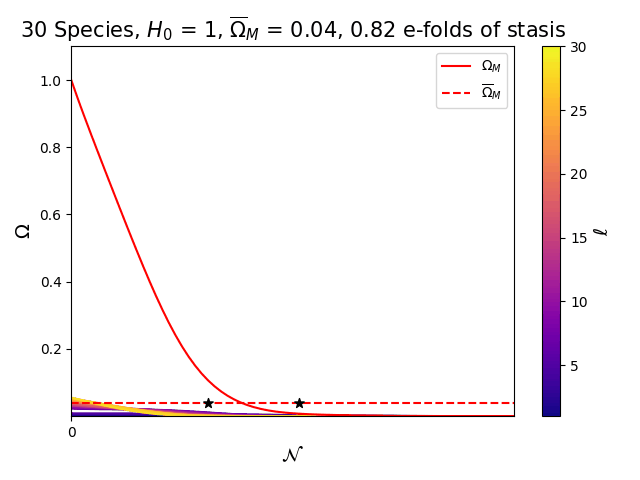

In [11]:
display(Image(filename='stasis_plots.gif'))


Ta-Da!